# Assignment 8

In the module, the attention mechanism implementation is based on a single sequence input and iterated over every token individually. This implementation matches the block diagram in the module. 

Convert the implementation to batched using `BATCH_SIZE` to take advantage of PyTorch and a GPGPU device. Code updates and hints towards batch-by-batch processing have been provided throughout the implementation, including the dataset class NMTDataset. 

General steps towards batching in an RNN attention neural network:

- Each sequence is created as a fixed-length tensor and padded to fill the tokens to the 
length after the EOS token. 
- Training has to input the sequences batch by batch.
- It is permissible to go over the tokens one by one, but in batches.
- RNN layers have batch_first to control the batch order, either batch-sequence-features or sequence-batch-features for True and False, respectively. The initial hidden 
layer order is always the same, sequence-batch-features

Show that batched implementation is faster and generates the same error convergence.

In [1]:
# Import necessary modules
import sys
import time
import torch
import random
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from nmt_dataset.nmt_dataset import \
    NMTDataset, GO_token, EOS_token, SEQ_MXLEN
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
# Set PyTorch device according to system offering
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='mps')

In [3]:
# Establish "global" hyperparameter variables and load in the dataset
HIDDEN_N = 128
BATCH_SIZE = 8
DATASET_SIZE = BATCH_SIZE * (100000 // BATCH_SIZE)
dataset = NMTDataset('nmt_dataset/eng-fra.txt', DATASET_SIZE)
dataset_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
print('Example of an item from the dataset:')
dataset_loader.dataset[0]

Example of an item from the dataset:


(tensor([[3],
         [4],
         [5],
         [6],
         [7],
         [1],
         [2],
         [2],
         [2],
         [2]]),
 tensor([[3],
         [4],
         [5],
         [6],
         [7],
         [1],
         [2],
         [2],
         [2],
         [2]]))

In [4]:
# Create an encoder model
class Encoder(nn.Module):
    def __init__(self, n_input: int, n_hidden: int) -> None:
        super().__init__()
        self.n_input, self.n_hidden = n_input, n_hidden

        self.embedding_layer = nn.Embedding(n_input, n_hidden)
        self.rnn_cell = nn.GRU(n_hidden, n_hidden, batch_first=True)

    def forward(self, _x, _hn):
        _x_embedded = self.embedding_layer(_x).view(_x.shape[0], 1, -1)
        return self.rnn_cell(_x_embedded, _hn)

    def init_hidden(self, eval: bool = False):
        dim_1 = BATCH_SIZE
        if eval:
            dim_1 = 1
        return torch.zeros(1, dim_1, self.n_hidden, device=device)

encoder = Encoder(dataset.input_lang.n_words, HIDDEN_N).to(device)
encoder

Encoder(
  (embedding_layer): Embedding(3989, 128)
  (rnn_cell): GRU(128, 128, batch_first=True)
)

In [5]:
# Create a decoder model
class Decoder(nn.Module):
    def __init__(
        self, n_hidden: int, n_output: int,
        dropout_rate: float = 0.1
    ) -> None:
        super().__init__()
        self.n_hidden, self.n_output = n_hidden, n_output

        self.embedding = nn.Embedding(self.n_output, self.n_hidden)
        self.dropout = nn.Dropout(dropout_rate)
        self.attention = nn.Linear(n_hidden, n_hidden)
        self.w_c = nn.Linear(n_hidden * 2, n_hidden)
        self.rnn_cell = nn.GRU(n_hidden, n_hidden, batch_first=True)
        self.w_y = nn.Linear(n_hidden, n_output)

    def forward(self, _x, _hn, _encoder_outputs):
        _x_embedded = self.embedding(_x).view(_x.shape[1], 1, -1)
        _x_embedded = self.dropout(_x_embedded)
        _, _hn = self.rnn_cell(_x_embedded, _hn)
        _alignment_scores = torch.bmm(
            self.attention(_hn).permute(1, 0, 2),
            _encoder_outputs.permute(0, 2, 1)
        )
        _attention_weights = nn.functional.softmax(
            _alignment_scores, dim=2)
        _c_t = torch.bmm(_attention_weights, _encoder_outputs)
        _hidden_s_t = torch.cat([_hn.permute(1, 0, 2), _c_t], dim=2)
        _hidden_s_t = torch.tanh(self.w_c(_hidden_s_t))
        _output = nn.functional.log_softmax(self.w_y(_hidden_s_t), dim=2)
        return _output, _hn, _attention_weights

    def init_hidden(self, eval: bool = False):
        dim_1 = BATCH_SIZE
        if eval:
            dim_1 = 1
        return torch.zeros(1, dim_1, self.n_hidden, device=device)

decoder = Decoder(HIDDEN_N, dataset.output_lang.n_words).to(device)
decoder 

Decoder(
  (embedding): Embedding(2569, 128)
  (dropout): Dropout(p=0.1, inplace=False)
  (attention): Linear(in_features=128, out_features=128, bias=True)
  (w_c): Linear(in_features=256, out_features=128, bias=True)
  (rnn_cell): GRU(128, 128, batch_first=True)
  (w_y): Linear(in_features=128, out_features=2569, bias=True)
)

In [6]:
# Create the loss function and optimizers for training the above models
loss_function = nn.NLLLoss()
encoder_optimizer = torch.optim.Adam(encoder.parameters())
decoder_optimizer = torch.optim.Adam(decoder.parameters())

In [7]:
# Create and run a function to train the above models
def train(
    _encoder: Encoder, _decoder: Decoder, debug_step: int = None
) -> tuple[Encoder, Decoder]:
    total_loss = 0
    for batch_index, (seq1, seq2) in enumerate(dataset_loader):
        seq1 = seq1.to(device)
        seq2 = seq2.to(device)

        encoder_hn = _encoder.init_hidden()

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs = torch.zeros(
            SEQ_MXLEN, BATCH_SIZE, _encoder.n_hidden, device=device)

        loss = torch.Tensor([0]).squeeze().to(device)

        with torch.set_grad_enabled(True):

            for encoder_index in range(SEQ_MXLEN):
                encoder_output, encoder_hn = _encoder(
                    seq1[:, encoder_index:encoder_index+1, :], encoder_hn)
                encoder_outputs[encoder_index] = encoder_output.squeeze(1)
            encoder_outputs = encoder_outputs.permute(1, 0, 2)

            decoder_input = torch.tensor(
                [[GO_token] * BATCH_SIZE], device=device)
            decoder_hn = encoder_hn

            for decoder_index in range(SEQ_MXLEN):
                decoder_output, decoder_hn, _ = _decoder(
                    decoder_input, decoder_hn, encoder_outputs)
                loss += loss_function(
                    decoder_output.squeeze(1),
                    seq2[:, decoder_index, :].squeeze(1)
                ).mean()
                decoder_input = seq2[:, decoder_index, :].permute(1, 0)

            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()

        total_loss += loss.item() / SEQ_MXLEN

        if debug_step:
            if batch_index % debug_step == 0:
                sys.stdout.write(
                    f'\r{batch_index // debug_step:3d}/'
                    f'{DATASET_SIZE // debug_step:3d} | '
                    f'Loss: {total_loss / debug_step:3.2f}')
                sys.stdout.flush()
                total_loss = 0
    return _encoder, _decoder

In [8]:
# Perform training
start_time = time.time()
train(encoder, decoder, debug_step=1000)
runtime = time.time() - start_time
print(f'\nRuntime (sec): {round(runtime, 2)}')

 12/100 | Loss: 0.13
Runtime (sec): 1034.87


In [24]:
# Create a function for using the encoder
# and decoder to translate a given sequence
def translate_sequence(
    _encoder: Encoder, _decoder: Decoder, _seq1: torch.Tensor,
    max_length: int = SEQ_MXLEN
) -> tuple:
    with torch.no_grad():
        encoder_hn = _encoder.init_hidden(eval=True)

        len_seq1 = _seq1.size()[0]
        _seq1 = _seq1.unsqueeze(0)

        encoder_outputs = torch.zeros(
            max_length, 1, _encoder.n_hidden, device=device)

        for encoder_index in range(len_seq1):
            encoder_output, encoder_hn = _encoder(
                _seq1[:, encoder_index:encoder_index+1, :], encoder_hn)
            encoder_outputs[encoder_index] += encoder_output.squeeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        decoder_input = torch.tensor([[GO_token]], device=device)
        decoder_hn = encoder_hn

        decoder_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        for decoder_index in range(max_length):
            decoder_output, decoder_hn, decoder_attention = _decoder(
                decoder_input, decoder_hn, encoder_outputs)
            decoder_attentions[decoder_index] = decoder_attention.data

            # Output the word index with the highest probability
            _, top_index = decoder_output.data.topk(1)
            if top_index.item() != EOS_token:
                decoder_words.append(
                    dataset.output_lang.ix2word[top_index.item()])
            else:
                break

            decoder_input = top_index.squeeze(0)
    
    return decoder_words, decoder_attentions[:decoder_index+1]

In [25]:
# Create a function for translating a given number of random sequences
def translate_random_sequences(
    _encoder: Encoder, _decoder: Decoder, n_seqs: int = 10
) -> None:
    for _ in range(n_seqs):
        sample_index = random.randint(0, DATASET_SIZE - 1)
        pair = dataset.pairs[sample_index]
        seq1 = dataset[sample_index][0].to(device)

        output_words, _ = translate_sequence(_encoder, _decoder, seq1)

        print(f'seq1: {pair[0]} | seq2: {pair[1]} | '
              f'result: {" ".join(output_words)}')

In [26]:
# Test out the encoder/decoder model with a few random sequences
translate_random_sequences(encoder, decoder)

seq1: nous sommes dans une bibliotheque . | seq2: we are in a library . | result: we re in a library .
seq1: nous ne sommes pas libres . | seq2: we re not free . | result: we re not free .
seq1: vous n etes pas encore morts . | seq2: you re not dead yet . | result: you re not dead yet .
seq1: il est un bon perdant . | seq2: he is a good loser . | result: he is a good loser .
seq1: je ne suis pas ta fille . | seq2: i m not your daughter . | result: i m not your daughter .
seq1: il est rarement de bonne humeur . | seq2: he is rarely in a good mood . | result: he is rarely in a good mood .
seq1: tu es responsable de ce resultat . | seq2: you are responsible for the result . | result: you are responsible for the result .
seq1: je vais etre mariee . | seq2: i m going to get married . | result: i m going to get married .
seq1: elle est sourde a mes conseils . | seq2: she is deaf to my advice . | result: she is friendly to my .
seq1: nous sommes tous amis . | seq2: we re all friends . | resul

In [27]:
# Create function to plot the attention values between a single pair
def plot_attention(_seq1, _seq2, _attentions):
    figure = plt.figure(figsize=(4, 4))
    ax = figure.add_subplot(111)
    cax = ax.matshow(_attentions, cmap='gray')
    figure.colorbar(cax, fraction=0.03, pad=0.1)
    _seq1 = _seq1.split(' ')
    _seq2 = _seq2.split(' ')
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(_seq1)))
    ax.set_yticks(np.arange(len(_seq2)))
    ax.set_xticklabels(_seq1, rotation=90)
    ax.set_yticklabels(_seq2)
    plt.show()

In [30]:
# Create a function to translate a sequence and plot the attention values
def translate_and_plot_attention(
    _encoder: Encoder, _decoder: Decoder, _seq1
) -> None:
    seq2, attentions = translate_sequence(
        _encoder, _decoder, dataset.sentence_to_sequence(_seq1).to(device))
    _seq1 += ' <EOS>'
    seq2 = ' '.join(seq2) + ' <EOS>'
    print(f'seq1: {_seq1} | seq2: {seq2}')
    plot_attention(_seq1, seq2, attentions.numpy())

seq1: je ne compare pas tom a mary . <EOS> | seq2: i m not comparing tom to mary . <EOS>


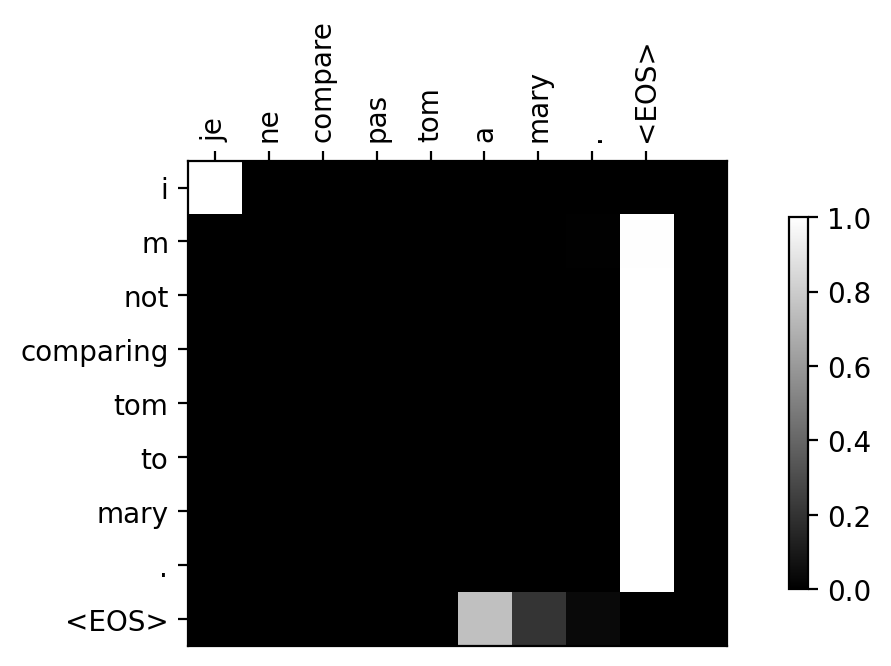

seq1: elle est trop petit . <EOS> | seq2: she too too sensitive . <EOS>


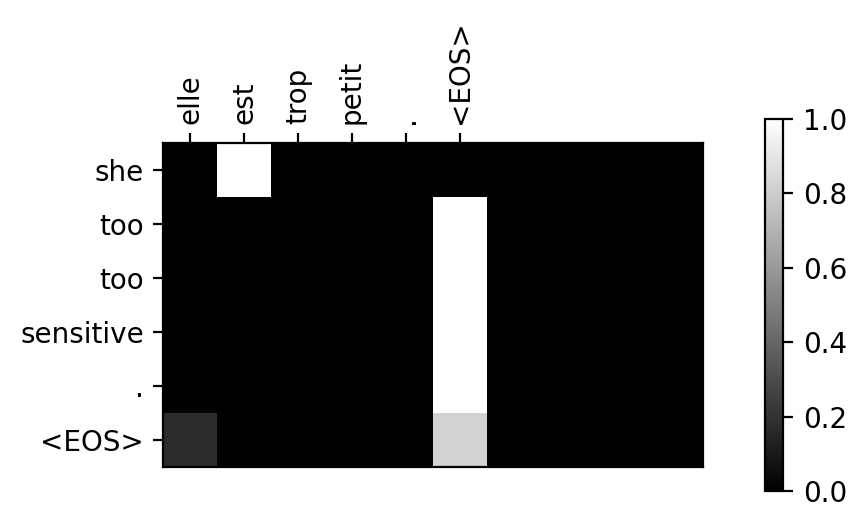

seq1: je ne crains pas de mourir . <EOS> | seq2: i m not scared of die . <EOS>


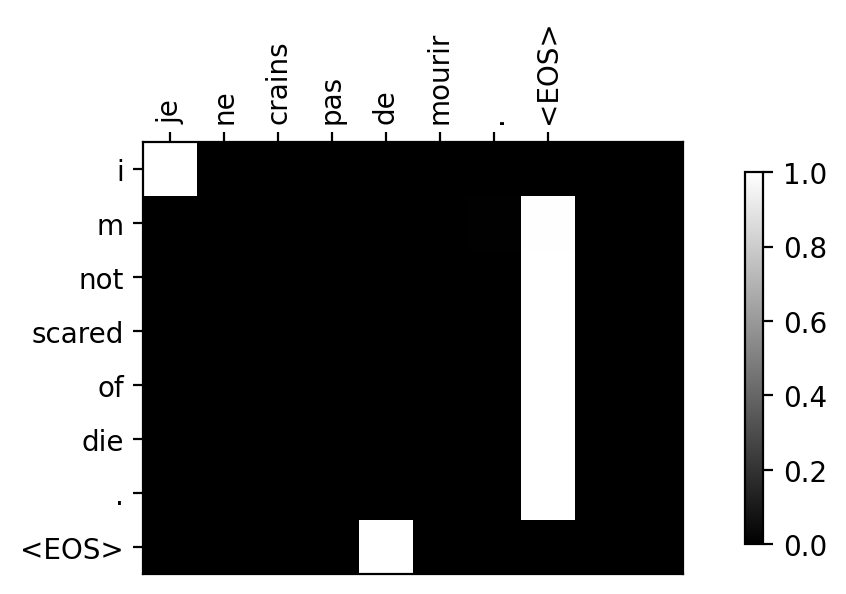

seq1: tu es parfois si pueril . <EOS> | seq2: you are so childish sometimes . <EOS>


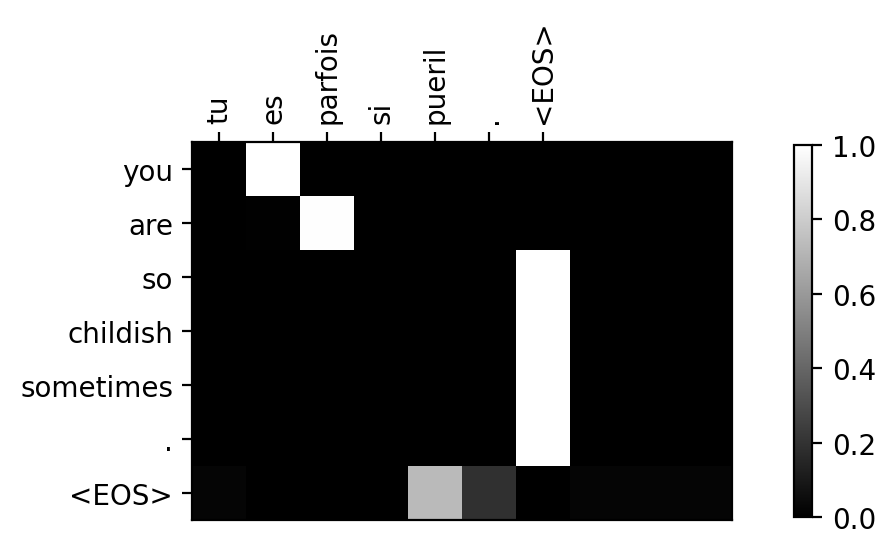

In [31]:
# Translate several sequences and plot their attentions
translate_and_plot_attention(encoder, decoder, 'je ne compare pas tom a mary .')
translate_and_plot_attention(encoder, decoder, 'elle est trop petit .')
translate_and_plot_attention(encoder, decoder, 'je ne crains pas de mourir .')
translate_and_plot_attention(encoder, decoder, 'tu es parfois si pueril .')